# Computer Vision: Object Recognition

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#
import pickle
# Machine Learning
from sklearn.pipeline import Pipeline  
from sklearn.linear_model import LogisticRegression  

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d
                                      
def load_cifar(filenames):
    training_images = []
    training_labels = []

    for file_name in filenames:
        unpickled_images = unpickle(file_name)
        images, labels = unpickled_images[b'data'], unpickled_images[b'labels']
        images = np.reshape(images,(-1, 3, 32, 32))
        images = np.transpose(images, (0, 2, 3, 1))
        training_images.append(images)
        training_labels += labels

    return np.vstack(training_images), training_labels


print("Loading the training set")
training_files = [f'/work/data_batch_{i}' for i in range(1, 6)]
training_images, int_training_labels = load_cifar(training_files)

print("Loading the testing set")
testing_files = ['/work/test_batch']
testing_images, int_testing_labels = load_cifar(testing_files)

print("Loading the labels")
label_names = unpickle('/work/batches.meta')[b'label_names']
training_labels = [str(label_names[_]) for _ in int_training_labels]
testing_labels = [str(label_names[_]) for _ in int_testing_labels]

Loading the training set
Loading the testing set
Loading the labels


b'frog'


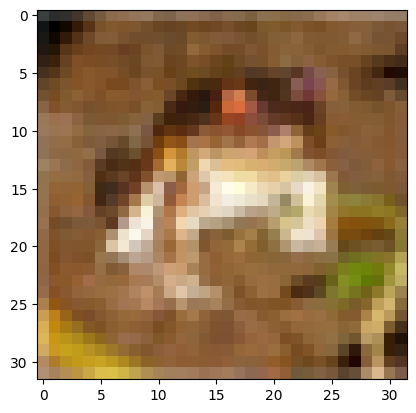

In [3]:
print(training_labels[0])
plt.imshow(training_images[0])
plt.show()

b'cat'


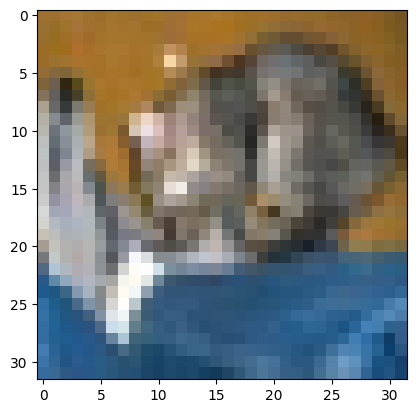

In [4]:
print(testing_labels[0])
plt.imshow(testing_images[0])
plt.show()

In [5]:
training_images.shape

(50000, 32, 32, 3)

In [6]:
# RGB values of the top left pixel
training_images[0][0, 0]  

array([59, 62, 63], dtype=uint8)

### Feature Construction

- Calculating Mean Pixel Values

In [7]:
# Average RGB Values together, and reshape them to make a ID vector for each image
avg_training_images = training_images.mean(axis=3).reshape(50000,-1)  
avg_testing_images = testing_images.mean(axis=3).reshape(10000,-1)  

print(avg_training_images.shape)

(50000, 1024)


In [8]:
%run ./Base.ipynb

- Baseline Model: Using MPV

In [9]:
clf = LogisticRegression(max_iter=100, solver='saga')  

ml_pipeline = Pipeline([  
    ('classifier', clf)
])

params = {  
    'classifier__C': [1e-1, 1e0, 1e1]
}

print("Average Pixel Value + LogReg\n==========================")
advanced_grid_search(   
    avg_training_images, training_labels, avg_testing_images, testing_labels, 
    ml_pipeline, params
)

Average Pixel Value + LogReg
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/

(Pipeline(steps=[('classifier', LogisticRegression(C=10.0, solver='saga'))]),
 array(["b'frog'", "b'truck'", "b'ship'", ..., "b'dog'", "b'dog'",
        "b'dog'"], dtype='<U13'))

### Feature Extraction: Histogram of Oriented Gradients

In [10]:
# Scikit-Image Libraries
from skimage.feature import hog  
from skimage import data, exposure  
from skimage.transform import resize  

(1568,)


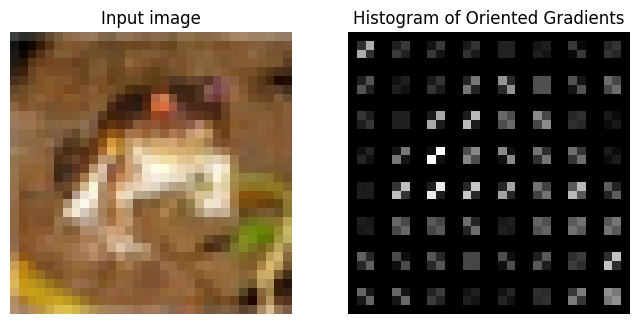

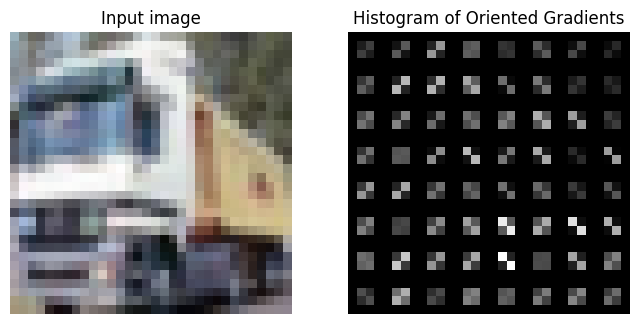

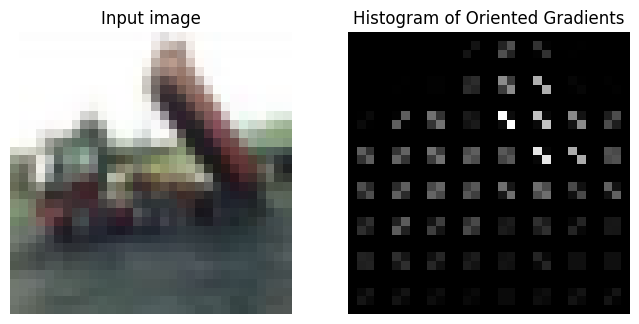

In [11]:
for image in training_images[:3]:

    hog_features, hog_image = hog(  
        image,
        orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True,
        channel_axis=-1, transform_sqrt=True, block_norm='L2-Hys')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)  

    ax1.axis('off')  
    ax1.imshow(image, cmap=plt.cm.gray)  
    ax1.set_title('Input image')  

    ax2.axis('off')  
    ax2.imshow(hog_image, cmap=plt.cm.gray)  
    ax2.set_title('Histogram of Oriented Gradients')  
    
print(hog_features.shape)  
plt.show()

- Calculating HOG's for CIFAR-10

In [12]:
from tqdm import tqdm

In [13]:
def calculate_hogs(images):  
    hog_descriptors = []
    for image in tqdm(np.sqrt(images)):
        hog_descriptors.append(hog(
            image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2), 
            channel_axis=-1, transform_sqrt=True, block_norm='L2-Hys', visualize=False
        ))

    return np.squeeze(hog_descriptors)

hog_training = calculate_hogs(training_images)
hog_testing = calculate_hogs(testing_images)

100%|██████████| 10000/10000 [00:10<00:00, 966.60it/s]


In [14]:
print("HOG + LogReg\n=====================")
advanced_grid_search(
    hog_training, training_labels, hog_testing, testing_labels, 
    ml_pipeline, params
)

HOG + LogReg
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/si

(Pipeline(steps=[('classifier', LogisticRegression(C=0.1, solver='saga'))]),
 array(["b'dog'", "b'ship'", "b'automobile'", ..., "b'cat'",
        "b'automobile'", "b'horse'"], dtype='<U13'))

- Optimizing Dimension Reduction with PCA

Text(0, 0.5, '% of Explained Variance')

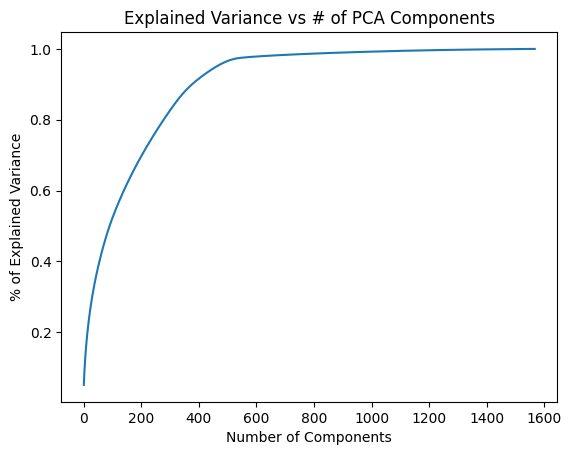

In [15]:
from sklearn.decomposition import PCA  

num_hog_features = hog_training.shape[1]  

p = PCA(n_components=num_hog_features)  
p.fit(hog_training)  

plt.plot(p.explained_variance_ratio_.cumsum())  
plt.title('Explained Variance vs # of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('% of Explained Variance')

- Using Reduced HOG Dimension as Features

In [16]:
p = PCA(n_components=600)  # A

hog_training_pca = p.fit_transform(hog_training)  # B
hog_testing_pca = p.transform(hog_testing)  # B

print("HOG + PCA + LogReg\n=====================")
advanced_grid_search(  # C
    hog_training_pca, training_labels, hog_testing_pca, testing_labels, 
    ml_pipeline, params
)

HOG + PCA + LogReg
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
               precision    recall  f1-score   support

  b'airplane'       0.60      0.60      0.60      1000
b'automobile'       0.68      0.68      0.68      1000
      b'bird'       0.44      0.37      0.40      1000
       b'cat'       0.42      0.35      0.39      1000
      b'deer'       0.47      0.50      0.48      1000
       b'dog'       0.48      0.45      0.46      1000
      b'frog'       0.55    

(Pipeline(steps=[('classifier', LogisticRegression(C=0.1, solver='saga'))]),
 array(["b'dog'", "b'ship'", "b'truck'", ..., "b'cat'", "b'automobile'",
        "b'horse'"], dtype='<U13'))

### Feature Learning with VGG-11

- Loading a Pre-trained VGG-11 Model & Standarize Images

In [17]:
import torchvision.models as models
import torch.nn as nn

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
vgg_model = models.vgg11(pretrained='imagenet')  # A

normalized_training_images = ((training_images/255) - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # B
normalized_testing_images = ((testing_images/255) - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # B

/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:01<00:00, 413MB/s]


- Loading Data into PyTorch DataLoaders

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

training_images_tensor = torch.Tensor(normalized_training_images.transpose(0, 3, 1, 2))  
training_labels_tensor = torch.Tensor(int_training_labels).type(torch.LongTensor)  

training_dataset = TensorDataset(training_images_tensor, training_labels_tensor)  
training_dataloader = DataLoader(training_dataset, shuffle=True, batch_size=2048)  


testing_images_tensor = torch.Tensor(normalized_testing_images.transpose(0, 3, 1, 2))  
testing_labels_tensor = torch.Tensor(int_testing_labels).type(torch.LongTensor)  

testing_dataset = TensorDataset(testing_images_tensor, testing_labels_tensor)  
testing_dataloader = DataLoader(testing_dataset, shuffle=True, batch_size=2048)  

- Helper Function to Aggregate Training & Testing Matrices

In [20]:
from tqdm import tqdm

def get_vgg_features(feature_extractor):
    print("Extracting features for training set")
    extracted_training_images = []
    shuffled_training_labels = []
    for batch_idx, (data_, target_) in tqdm(enumerate(training_dataloader)):
        extracted_training_images.append(feature_extractor(data_).detach().numpy().squeeze((2, 3)))
        shuffled_training_labels += target_

    print("Extracting features for testing set")
    extracted_testing_images = []
    shuffled_testing_labels = []
    for batch_idx, (data_, target_) in tqdm(enumerate(testing_dataloader)):
        extracted_testing_images.append(feature_extractor(data_).detach().numpy().squeeze((2, 3)))
        shuffled_testing_labels += target_

    return np.vstack(extracted_training_images), shuffled_training_labels, np.vstack(extracted_testing_images), shuffled_testing_labels
        

- Using Pre-Trained VGG-11 Features

In [21]:
transformed_training_images, shuffled_training_labels, transformed_testing_images, shuffled_testing_labels = get_vgg_features(vgg_model.features)  # A

print("VGG11(Imagenet) + LogReg\n=====================")
advanced_grid_search(
    transformed_training_images, shuffled_training_labels, 
    transformed_testing_images, shuffled_testing_labels,   
    ml_pipeline, params
)

Extracting features for training set
25it [00:30,  1.20s/it]
Extracting features for testing set
5it [00:06,  1.21s/it]
VGG11(Imagenet) + LogReg
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: Convergence

(Pipeline(steps=[('classifier', LogisticRegression(C=0.1, solver='saga'))]),
 array([3, 7, 6, ..., 1, 5, 9]))

- Altering VGG-11 to Classify 10 Labels & Rerandomize Classification Weights

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

fine_tuned_vgg_model = models.vgg11(pretrained='imagenet')  

fine_tuned_vgg_model.classifier[-1].out_features = 10  

for layer in fine_tuned_vgg_model.classifier:  
    if hasattr(layer, 'weight'):  
        torch.nn.init.xavier_uniform_(layer.weight)  
    if hasattr(layer, 'bias'):  
        nn.init.constant_(layer.bias.data, 0)  

/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- Setting Up Training Arguments for VGG-11

In [23]:
import torch.optim as optim  

criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(fine_tuned_vgg_model.parameters(), lr=0.01, momentum=0.9)  

n_epochs = 15  
print_every = 10  
valid_loss_min = np.Inf  
total_step = len(training_dataloader)  

train_loss, val_loss, train_acc, val_acc = [], [], [], []  

In [24]:
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(training_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()  # clears the gradient or else they accumulate
        
        outputs = fine_tuned_vgg_model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}%')
    
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        fine_tuned_vgg_model.eval()
        for data_t, target_t in (testing_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = fine_tuned_vgg_model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testing_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}%\n')

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(fine_tuned_vgg_model.state_dict(), 'vgg_cifar10.pt')
            print('Saving Parameters')
            
    fine_tuned_vgg_model.train()

Epoch 1

Epoch [1/15], Step [0/25], Loss: 8.9047
Epoch [1/15], Step [10/25], Loss: 2.1408
Epoch [1/15], Step [20/25], Loss: 1.2998

train-loss: 2.2926, train-acc: 39.1840%
validation loss: 1.1197, validation acc: 59.8900%

Saving Parameters
Epoch 2

Epoch [2/15], Step [0/25], Loss: 1.1631
Epoch [2/15], Step [10/25], Loss: 0.9191
Epoch [2/15], Step [20/25], Loss: 0.8598

train-loss: 1.6170, train-acc: 66.7380%
validation loss: 0.9413, validation acc: 73.2300%

Saving Parameters
Epoch 3

Epoch [3/15], Step [0/25], Loss: 0.7452
Epoch [3/15], Step [10/25], Loss: 0.6606
Epoch [3/15], Step [20/25], Loss: 0.6416

train-loss: 1.3063, train-acc: 76.0460%
validation loss: 0.8444, validation acc: 77.6700%

Saving Parameters
Epoch 4

Epoch [4/15], Step [0/25], Loss: 0.6060
Epoch [4/15], Step [10/25], Loss: 0.5553
Epoch [4/15], Step [20/25], Loss: 0.5524

train-loss: 1.1198, train-acc: 80.4060%
validation loss: 0.7797, validation acc: 80.0400%

Saving Parameters
Epoch 5

Epoch [5/15], Step [0/25], 

- Using a Fine-Tuned VGG-11 to Extract Features

In [25]:
cifar_fine_tuned_vgg_model = models.vgg11(pretrained='imagenet')  # A
cifar_fine_tuned_vgg_model.classifier[-1].out_features = 10  # A

cifar_fine_tuned_vgg_model.load_state_dict(torch.load('vgg_cifar10.pt', map_location=device))  # B

cifar_finetuned_training_images, shuffled_training_labels, cifar_finetuned_testing_images, shuffled_testing_labels = get_vgg_features(cifar_fine_tuned_vgg_model.features)  # B

print("Fine-tuned VGG11 + LogReg\n=====================")
advanced_grid_search(  # C
    cifar_finetuned_training_images, shuffled_training_labels, 
    cifar_finetuned_testing_images, shuffled_testing_labels, 
    ml_pipeline, params
)

Extracting features for training set
25it [00:29,  1.19s/it]
Extracting features for testing set
5it [00:05,  1.19s/it]
Fine-tuned VGG11 + LogReg
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: Convergenc

(Pipeline(steps=[('classifier', LogisticRegression(C=0.1, solver='saga'))]),
 array([7, 0, 5, ..., 6, 3, 6]))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=22b9eb2e-884d-41e7-ab0a-13f400fa916c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>